In [149]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [150]:
# Se cargan las diferentes dependencias necesarias
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import display


In [151]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
!pip install SpeechRecognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [153]:
import python_speech_features
import librosa
import librosa.display


In [154]:
from python_speech_features import mfcc
from python_speech_features import logfbank

In [155]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
   # sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
   # wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

(16000,)


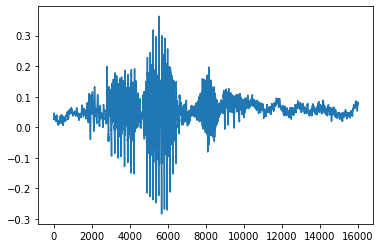

In [156]:
# Ejemplo de carga de un archivo
RutaFile="/content/gdrive/MyDrive/ProceSecuencial/AudioProcessing/data-commands-especto/spacenav-export/training/Derecha.3iftqpjo.ingestion-5489ddcb5b-h6jlk.s1.wav"
wave = load_wav_16k_mono(RutaFile)
print(wave.shape)
plt.plot(wave)
plt.show()



In [157]:

num_mfcc = 16


In [158]:
def preprocess(wave): 
    # Load wavefile
    signal, fs = librosa.load(wave, sr=16000)
    
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    
    return mfccs.transpose(), signal

In [159]:
espectrograma, signal= preprocess(RutaFile)
print('Waveform shape:', wave.shape)
print('Spectrogram shape:', espectrograma.shape)
print('Audio playback')
display.display(display.Audio(wave, rate=16000))

Waveform shape: (16000,)
Spectrogram shape: (16, 16)
Audio playback


In [160]:
D = librosa.stft(signal)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

#fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
#ax.set(title='Now with labeled axes!')
#fig.colorbar(img, ax=ax, format="%+2.f dB")

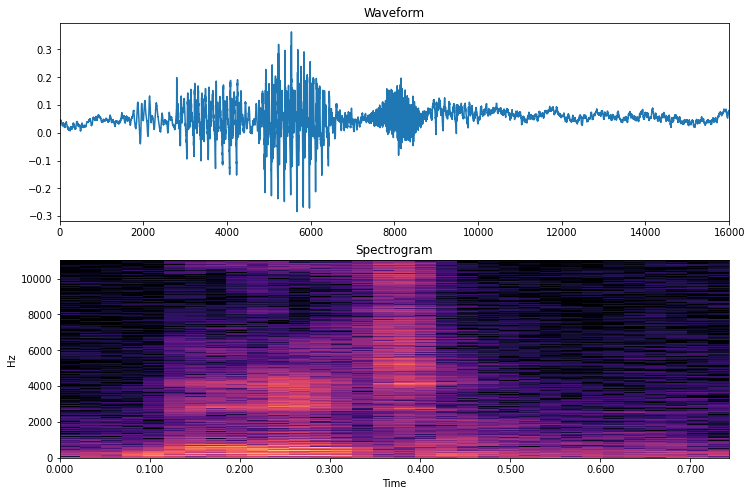

In [161]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(wave.shape[0])
axes[0].plot(timescale, wave.numpy())
axes[0].set_title('Waveform')
#axes[0].set_xlim([0, 32000])
axes[0].set_xlim([0, 16000])

#plot_spectrogram(espectrograma, axes[1])
librosa.display.specshow(S_db, x_axis='time', y_axis='linear')
axes[1].set_title('Spectrogram')
plt.show()

In [162]:
# Se cargan los diferentes archivos *.json que se van a usar en el proceso
# de entrenamiento
import os
directory = '/content/gdrive/MyDrive/ProceSecuencial/AudioProcessing/data-commands-especto/spacenav-export/training/'
files = os.listdir(directory)
files.sort() 
cantidadFiles = len(files)
# Variable donde se almacenaron los datos leidos de los archivos *.json
#Datos=np.zeros((cantidadFiles*624,3))
Datos=np.zeros((cantidadFiles,16,16))
i = 0

for file in files:
  RutaFile=directory + file
  #wave = load_wav_16k_mono(RutaFile)
  espectrograma, signal= preprocess(RutaFile)
  Datos[i,:,:]=espectrograma
  i+=1
print(Datos.shape)
Xtrain=tf.expand_dims(Datos, axis=3)
print(Xtrain.shape)



(40, 16, 16)
(40, 16, 16, 1)


In [163]:
YtrainIni=np.zeros((40,1))
for i in range(10):
    YtrainIni[i]=0

for i in range(10,20):
    YtrainIni[i]=1

for i in range(20,30):
    YtrainIni[i]=2

for i in range(30,40):
    YtrainIni[i]=3


print(YtrainIni)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]]


In [164]:
Ytrain= keras.utils.to_categorical(YtrainIni)
print(Ytrain)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 16, 16, 8)         80        
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4096)              0         
                                                      

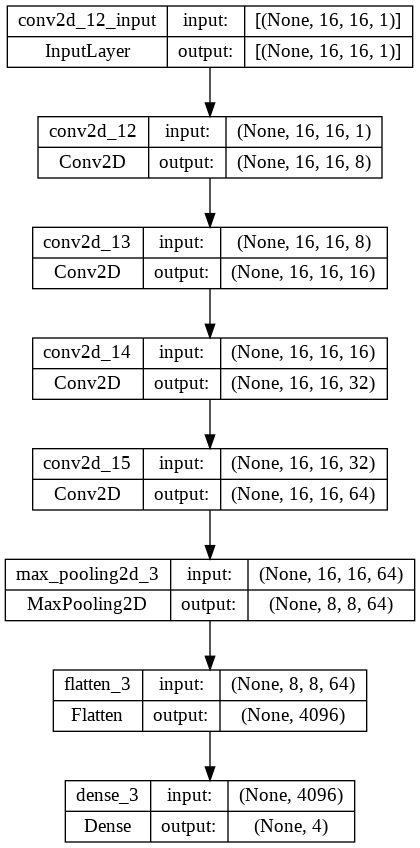

In [165]:

#Definición del modelo
modelo = keras.models.Sequential()
modelo.add(keras.layers.Conv2D(8, 3, activation="relu",padding="same", input_shape=(16,16,1)))
modelo.add(keras.layers.Conv2D(16, 3, activation="relu",padding="same"))
modelo.add(keras.layers.Conv2D(32, 3, activation="relu",padding="same"))
modelo.add(keras.layers.Conv2D(64, 3, activation="relu",padding="same"))
modelo.add(keras.layers.MaxPooling2D(pool_size=2,strides=2, padding='same'))
modelo.add(keras.layers.Flatten())
modelo.add(keras.layers.Dense(4, activation = 'softmax'))
modelo.summary()

keras.utils.plot_model(modelo, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [166]:
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = modelo.fit(Xtrain,Ytrain, epochs=30,batch_size=None, verbose=True)


Epoch 1/30
2/2 [==============================] - 1s 34ms/step - loss: 2.1391 - accuracy: 0.2750
Epoch 2/30
2/2 [==============================] - 0s 39ms/step - loss: 1.5496 - accuracy: 0.3500
Epoch 3/30
2/2 [==============================] - 0s 41ms/step - loss: 1.3638 - accuracy: 0.6000
Epoch 4/30
2/2 [==============================] - 0s 33ms/step - loss: 0.9976 - accuracy: 0.7250
Epoch 5/30
2/2 [==============================] - 0s 34ms/step - loss: 0.7974 - accuracy: 0.8000
Epoch 6/30
2/2 [==============================] - 0s 35ms/step - loss: 0.8110 - accuracy: 0.7000
Epoch 7/30
2/2 [==============================] - 0s 41ms/step - loss: 0.6950 - accuracy: 0.7500
Epoch 8/30
2/2 [==============================] - 0s 64ms/step - loss: 0.4975 - accuracy: 0.9500
Epoch 9/30
2/2 [==============================] - 0s 39ms/step - loss: 0.3787 - accuracy: 0.9500
Epoch 10/30
2/2 [==============================] - 0s 34ms/step - loss: 0.3283 - accuracy: 1.0000
Epoch 11/30
2/2 [============

2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - accuracy: 1.0000


[0.0012977865990251303, 1.0]

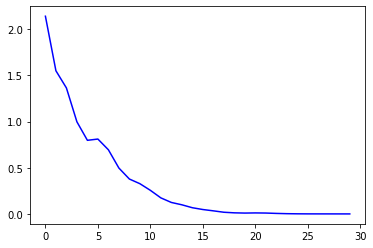

In [167]:
plt.plot(history.history["loss"],'b')
modelo.evaluate(Xtrain, Ytrain)

In [168]:
# Se cargan los diferentes archivos *.json que se van a usar en el proceso
# de testeo

import os
directory = '/content/gdrive/MyDrive/ProceSecuencial/AudioProcessing/data-commands-especto/spacenav-export/testing/'
files = os.listdir(directory)
files.sort() 

cantidadFiles = len(files)

DatosVal=np.zeros((cantidadFiles,16,16))
i = 0
for file in files:
  RutaFile=directory + file
  #wave = load_wav_16k_mono(RutaFile)
  espectrograma, signal= preprocess(RutaFile)

  DatosVal[i,:,:]=espectrograma
  i+=1
print(DatosVal.shape)
XVal=tf.expand_dims(DatosVal, axis=3)
print(XVal.shape)

(16, 16, 16)
(16, 16, 16, 1)


In [169]:
YValIni=np.zeros((16,1))
for i in range(4):
    YValIni[i]=0

for i in range(4,8):
    YValIni[i]=1

for i in range(8,12):
    YValIni[i]=2 

for i in range(12,16):
    YValIni[i]=3    

print(YValIni)
YVal= keras.utils.to_categorical(YValIni)

print(YVal)

[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [3.]
 [3.]
 [3.]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [170]:
modelo.evaluate(XVal, YVal)

1/1 [==============================] - 0s 53ms/step - loss: 0.1501 - accuracy: 0.9375


[0.15006990730762482, 0.9375]

1/1 [==============================] - 0s 193ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.80      1.00      0.89         4
           2       1.00      1.00      1.00         4
           3       1.00      0.75      0.86         4

    accuracy                           0.94        16
   macro avg       0.95      0.94      0.94        16
weighted avg       0.95      0.94      0.94        16

[[4 0 0 0]
 [0 4 0 0]
 [0 0 4 0]
 [0 1 0 3]]


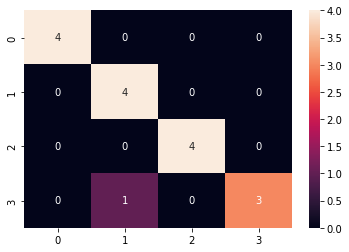

In [171]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ypredic=modelo.predict(XVal)

y_test_class = np.argmax(YVal,axis=1) 
y_pred_class = np.argmax(ypredic,axis=1) 

#Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class)) # Precision , Recall, F1-Score & Support
cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)
# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")